In [36]:
from fastai.vision.all import *
import fastai
import timm
import albumentations as A
import torch
import pandas as pd
import numpy as np
torch.cuda.set_device(1)

In [5]:
import os
def create_csvValid(path):
    output_path = os.path.join(path,"..","df_multilabel_test.csv")
    if (os.path.exists(output_path)):
        output_path_csv = open(output_path, "a")
    else:
        output_path_csv = open(output_path, "w")
        head = "images, class\n"
        output_path_csv.write(head)

    
    lista_archivos = list(os.walk(path))
    lista_archivos.sort()
    for carpeta in lista_archivos:
#         print(carpeta[0])
        video = carpeta[0].split(os.path.sep)[-1]
        for files in carpeta[2]:
            if "images_labelSmoothing.csv" in files:
                leer = open(os.path.join(carpeta[0],files))
                leer.readline()
                for l in leer:
                    escribir = ""
                    l = l.split(",")
                    for clas in l[1:]:
                        if float(clas)>0:
                            escribir= escribir +str(l.index(clas)-1) +" "
                    escribir = escribir[:-1]
                    if len(escribir)==0:
                        escribir = escribir+ "0"
                    escribir = escribir + "\n"
                    output_path_csv.write(video+os.path.sep+"images"+os.path.sep+l[0]+","+escribir)
#                     print(l)

In [6]:
create_csvValid("./dataset77_Marco/test")

In [2]:
dfValid = pd.read_csv('./dataset77_Marco/df_multilabel_train.csv')
dfTest = pd.read_csv('./dataset77_Marco/df_multilabel_test.csv')

prueba = dfValid
prueba = prueba.iloc[np.random.permutation(len(prueba))]
prueba = prueba[0:int(len(prueba)*0.1)]
# In[6]:
# Aquí debería hacer dos df diferentes. Uno para entrenamiento y otro para validación. En este caso 
# usa para entrenar el set de entrenamiento y validación. Imagino que la división la hará por programa
# dfValid = dfValid[(dfValid.set == 'training') | (dfValid.set == 'validation')]

# Hay que modificar esto para que haya set de validación. Hacer un vector random y que esté entre las primeras 
# 0.1 posiciones si está se devuelve 
def is_valid(path):
    name = path[0]
#     return (dfValid[dfValid['challenge_id']==name])['set'].values[0]=='validation'
    return (dfValid[dfValid['images']==name]).values[0] in prueba.images.values
    
# In[13]:

def get_class(path):
    name = path[0]
    return (dfValid[dfValid['images']==name])['class']


In [3]:
dfValid.loc[:,'images']=dfValid['images'].apply(lambda x: "./dataset77_Marco/train/"+x)

In [4]:
dfTest.loc[:,'images']=dfTest['images'].apply(lambda x: "./dataset77_Marco/test/"+x)

In [5]:
dfValid['split'] = False
dfTest['split'] = True

In [6]:
dfTotal = pd.concat([dfValid,dfTest])

In [12]:
dfTotal.to_csv('df_multilabel_Total.csv')

In [ ]:
def get_dls(presize=512,size=384,M=0,bs=4):
    db = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
             splitter=ColSplitter(2),
             get_x = ColReader(0,suff='.jpg'),
             get_y=ColReader(1,label_delim=' '),
             item_tfms = [Resize(presize)], # CropPad(200,200)
             batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=False,flip_vert=False,
                  max_rotate=0.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                         Normalize.from_stats(*imagenet_stats)])
    dls = db.dataloaders(dfTotal,bs=bs)
    return dls


In [8]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=4),
    SaveModelCallback(fname='Convnext_Multiclass',monitor='accuracy_multi'),
    # SaveModelCallback(fname='Resnet50_Multiclass',monitor='cohen_kappa_score'),
    ReduceLROnPlateau(patience=10)
]

In [8]:
dlsTrain = get_dls()

learn = cnn_learner(dlsTrain, "convnext_base", pretrained=True, metrics=[accuracy_multi,F1ScoreMulti(),PrecisionMulti(),RecallMulti(),RocAucMulti()]
                    , cbs = callbacks)

/opt/anaconda/envs/fastai/lib/python3.10/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


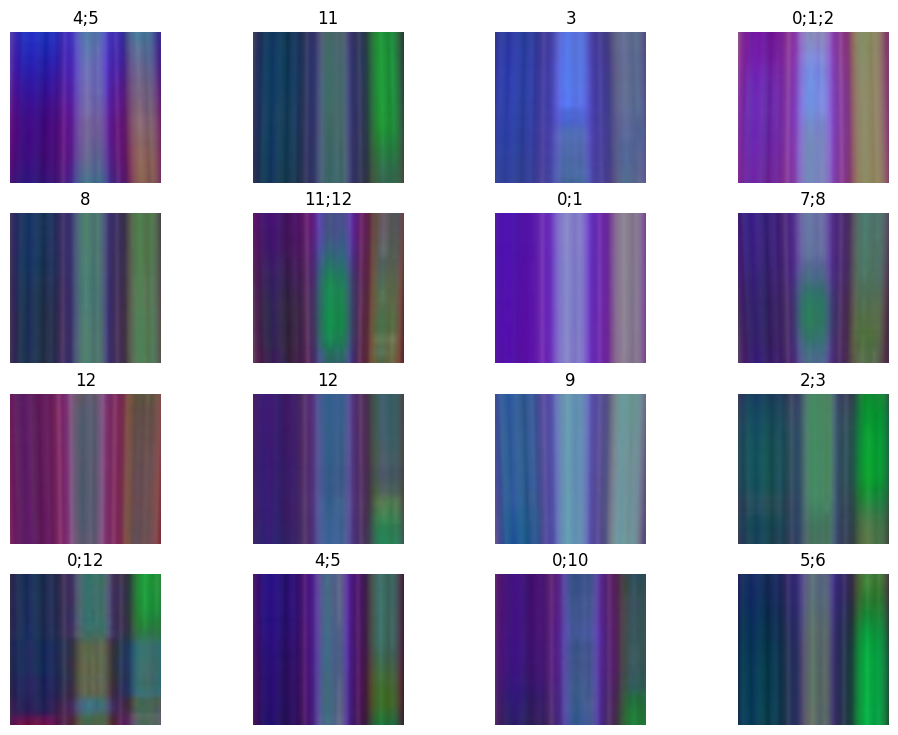

In [10]:
dlsTrain.show_batch(max_n=100, figsize=(12,9))

In [9]:
class BCEWithLogitsLossFlat(BaseLoss):
    "Same as `nn.BCEWithLogitsLoss`, but flattens input and target."
    @use_kwargs_dict(keep=True, weight=None, reduction='mean', pos_weight=None)
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, **kwargs):
        if kwargs.get('pos_weight', None) is not None and kwargs.get('flatten', None) is True:
            raise ValueError("`flatten` must be False when using `pos_weight` to avoid a RuntimeError due to shape mismatch")
        if kwargs.get('pos_weight', None) is not None: kwargs['flatten'] = False
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)

In [10]:
learn.loss_func = BCEWithLogitsLossFlat()

SuggestedLRs(valley=0.0030199517495930195)

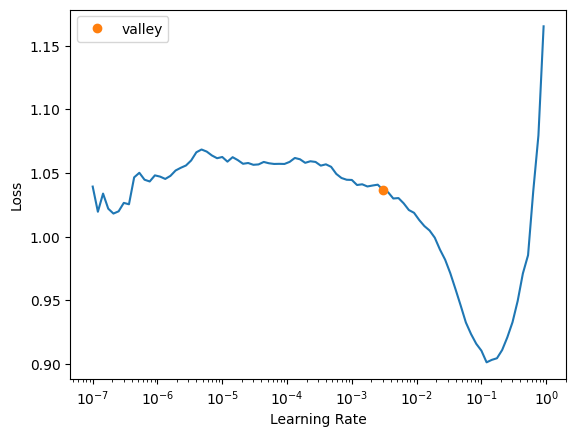

In [13]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.318165,0.276185,0.904918,04:27


Better model found at epoch 0 with accuracy_multi value: 0.9049183130264282.


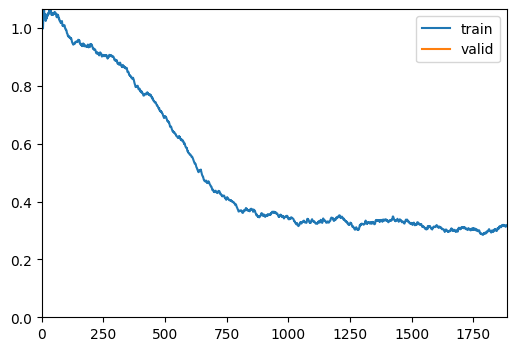

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.251524,0.211188,0.915864,09:44
1,0.234243,0.206671,0.917799,09:46
2,0.217572,0.194432,0.922388,09:46
3,0.210676,0.186537,0.926064,09:46
4,0.203945,0.186722,0.925926,09:47
5,0.188052,0.180714,0.928303,09:44
6,0.196251,0.173424,0.930431,09:45
7,0.188190,0.177457,0.929602,09:46
8,0.186656,0.174056,0.931316,09:47
9,0.172427,0.164183,0.934743,09:47


Better model found at epoch 0 with accuracy_multi value: 0.9158644080162048.


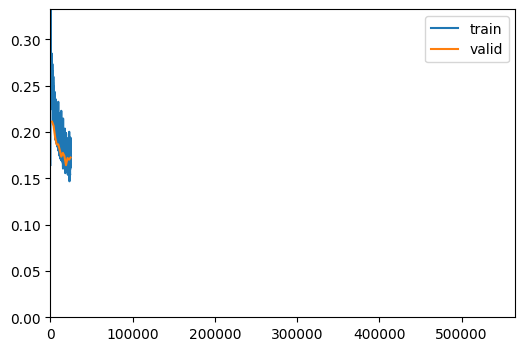

Better model found at epoch 1 with accuracy_multi value: 0.9177992343902588.
Better model found at epoch 2 with accuracy_multi value: 0.9223880171775818.
Better model found at epoch 3 with accuracy_multi value: 0.9260643124580383.
Better model found at epoch 5 with accuracy_multi value: 0.9283031225204468.
Better model found at epoch 6 with accuracy_multi value: 0.9304314851760864.
Better model found at epoch 8 with accuracy_multi value: 0.9313156008720398.
Better model found at epoch 9 with accuracy_multi value: 0.9347434043884277.
Better model found at epoch 11 with accuracy_multi value: 0.9351577162742615.
No improvement since epoch 9: early stopping


In [22]:
learn.fine_tune(300,base_lr=3e-3)

In [30]:
learn.save("Convnext_Multiclass")

Path('models/Resnet50_Multiclass.pth')

In [9]:
learn.load('Convnext_Multiclass')

/opt/anaconda/envs/fastai/lib/python3.10/site-packages/fastai/learner.py:59: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [10]:
dbTest = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                 splitter=ColSplitter('split'),
                 get_x = ColReader(0,suff='.jpg'),
                 get_y=ColReader(1,label_delim=' '),
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(dfTotal,bs=4)

In [11]:
learn.dls = dlsTest

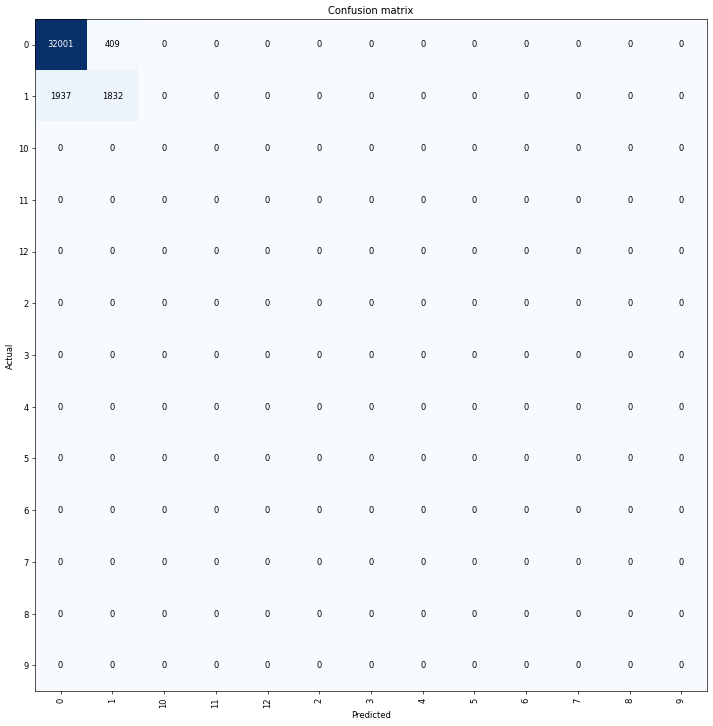

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [12]:
learn.validate()

(#6) [0.17010241746902466,0.9351577162742615,0.5631964778583375,0.8191119784848306,0.44596172788219,0.9355656271875239]

In [27]:
learn.export(fname='Convnext_Multiclass.pkl')

In [ ]:
predictions, truth =learn.get_preds()

pred2= []
treshold = 0.5
for predi in predictions:
    adc = []
    for p in predi:
        if p < treshold:
            adc.append(int(0))
        else: adc.append(int(1))
    pred2.append(adc)

In [ ]:
print(pred2[5])
print(predictions[5])
print(truth[5])

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
vis_arr = multilabel_confusion_matrix(truth, pred2)

In [ ]:
vis_arr

In [ ]:
labels = ["".join("c" + str(i)) for i in range(0, 13)]


In [33]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

In [ ]:
fig, ax = plt.subplots(4, 4, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

In [36]:
from sklearn.metrics import accuracy_score, top_k_accuracy_score, f1_score, multilabel_confusion_matrix

In [ ]:
with open('resultados_Convnext_Multiclass', 'w') as f:
    f.write('El accuracy obtenido en test es:\n')
    f.write(accuracy_score(np.argmax(preds,axis=1),gt))
    f.write('El F1-score que tenemos en test es:\n')
    f.write(f1_score(np.argmax(preds,axis=1),gt,average='macro'))

# Estas son las pruebas para la predicción del vídeo 002 del usuario 027

In [11]:
import os
def create_csvValid(path):
    output_path = os.path.join(path,"..","df_multilabel_test.csv")
    if (os.path.exists(output_path)):
        output_path_csv = open(output_path, "a")
    else:
        output_path_csv = open(output_path, "w")
        head = "images, class\n"
        output_path_csv.write(head)

    
    lista_archivos = list(os.walk(path))
    lista_archivos.sort()
    for carpeta in lista_archivos:
#         print(carpeta[0])
        video = carpeta[0].split(os.path.sep)[-1]
        for files in carpeta[2]:
            if "images_labelSmoothing.csv" in files:
                leer = open(os.path.join(carpeta[0],files))
                leer.readline()
                for l in leer:
                    escribir = ""
                    l = l.split(",")
                    for clas in l[1:]:
                        if float(clas)>0:
                            escribir= escribir +str(l.index(clas)-1) +" "
                    escribir = escribir[:-1]
                    if len(escribir)==0:
                        escribir = escribir+ "0"
                    escribir = escribir + "\n"
                    output_path_csv.write(video+os.path.sep+"images"+os.path.sep+l[0]+","+escribir)
#                     print(l)

In [12]:
create_csvValid("./dataset_Usr027Video002/test")

In [37]:
dfTest_027 = pd.read_csv('./dataset_Usr027Video002/df_multilabel_test.csv')

In [38]:
dfTest_027.loc[:,'images']=dfTest_027['images'].apply(lambda x: "./dataset_Usr027Video002/test/"+x)

In [39]:
dfTest_027['split'] = True

In [40]:
dfTotal = pd.concat([dfValid,dfTest_027])

In [41]:
dfTest_027

,images,class,split
0,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_0_to_77,0 1 2,True
1,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_1_to_78,0 1 2,True
2,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_2_to_79,0 1 2,True
3,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_3_to_80,0 1 2,True
4,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_4_to_81,0 1 2,True
...,...,...,...
1986,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_1986_to_2063,0 12,True
1987,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_1987_to_2064,0 12,True
1988,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_1988_to_2065,0 12,True
1989,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_1989_to_2066,0 12,True


In [18]:
dfTotal

,images,class,split
0,./dataset77_Marco/train/IDU001V001/images/IDU001V001_from_0_to_77,0 1,False
1,./dataset77_Marco/train/IDU001V001/images/IDU001V001_from_57_to_134,1,False
2,./dataset77_Marco/train/IDU001V001/images/IDU001V001_from_114_to_191,1 2,False
3,./dataset77_Marco/train/IDU001V001/images/IDU001V001_from_171_to_248,2,False
4,./dataset77_Marco/train/IDU001V001/images/IDU001V001_from_228_to_305,2,False
...,...,...,...
3977,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_1986_to_2063,0 12,True
3978,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_1987_to_2064,0 12,True
3979,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_1988_to_2065,0 12,True
3980,./dataset_Usr027Video002/test/IDU027V002_20220209_163603/images/IDU027V002_from_1989_to_2066,0 12,True


In [42]:
dbTest_027 = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                 splitter=ColSplitter('split'),
                 get_x = ColReader(0,suff='.jpg'),
                 get_y=ColReader(1,label_delim=' '),
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=384, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest_027 = dbTest_027.dataloaders(dfTotal,bs=4)

In [43]:
learn.dls = dlsTest_027

In [44]:
path_vid = './dataset_Usr027Video002/test/IDU027V002_20220209_163603'
imgs = []
probs = []
classes_pred = []


for _, line in dfTest_027.iterrows():
    # print(line[0])
    if "IDU027V002_20220209_163603" in line[0]:
        imgs.append(line[0])

for img in imgs:
    img = img + '.jpg'
    predic_class,_,probs1 = learn.predict(img)
    frame = [0]*13
    for preds in predic_class:
        frame[int(preds)]+=1
    # print(img)
    # print(predic_class)
    # print(frame)
    classes_pred.append(frame)
    probs.append(probs1)

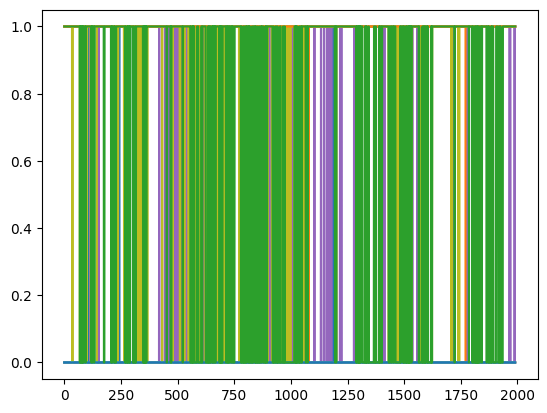

In [45]:
from matplotlib.pyplot import plot
plot(range(0,len(classes_pred)),[x for x in classes_pred])

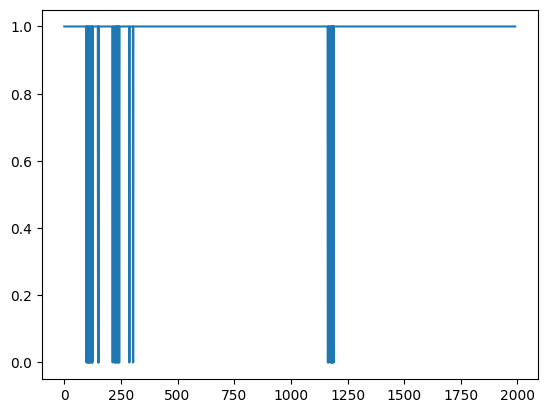

In [46]:
plot(range(0,len(classes_pred)),[x[0] for x in classes_pred])

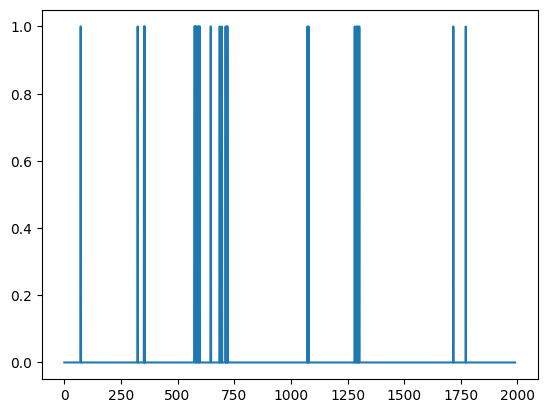

In [47]:
plot(range(0,len(classes_pred)),[x[1] for x in classes_pred])

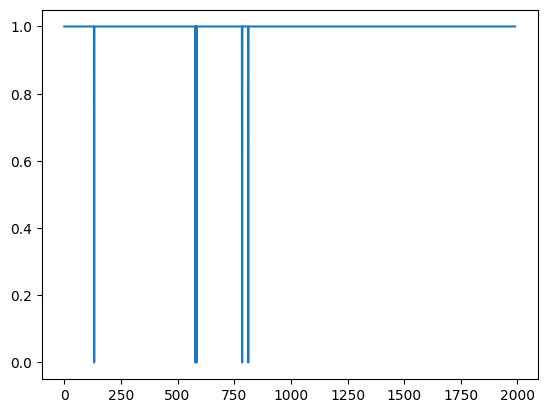

In [48]:
plot(range(0,len(classes_pred)),[x[2] for x in classes_pred])

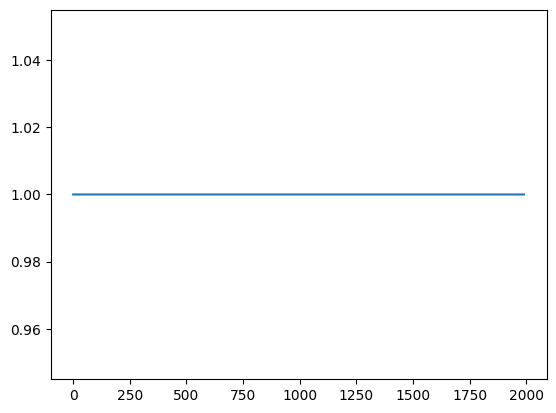

In [49]:
plot(range(0,len(classes_pred)),[x[3] for x in classes_pred])

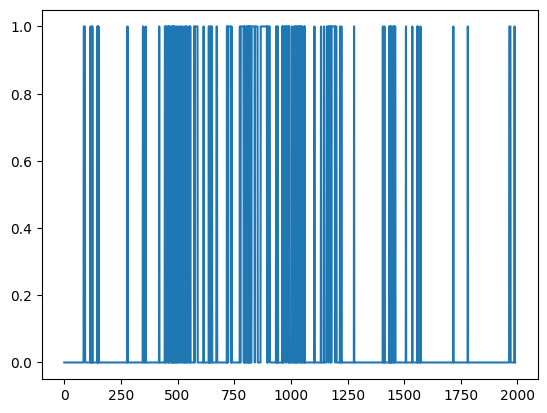

In [50]:
plot(range(0,len(classes_pred)),[x[4] for x in classes_pred])

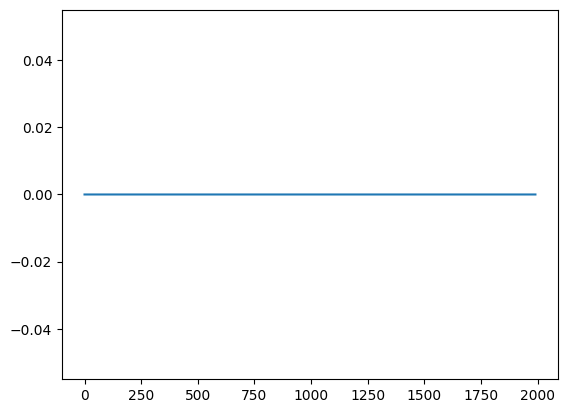

In [51]:
plot(range(0,len(classes_pred)),[x[5] for x in classes_pred])

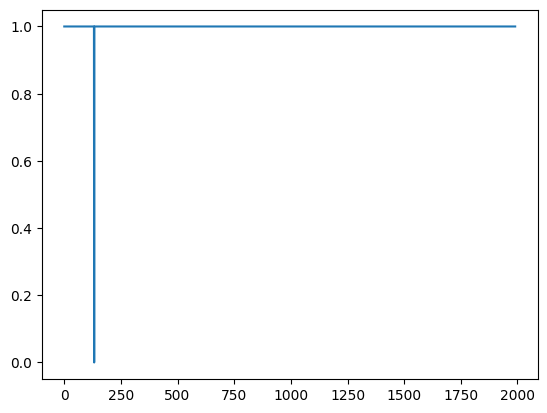

In [52]:
plot(range(0,len(classes_pred)),[x[6] for x in classes_pred])

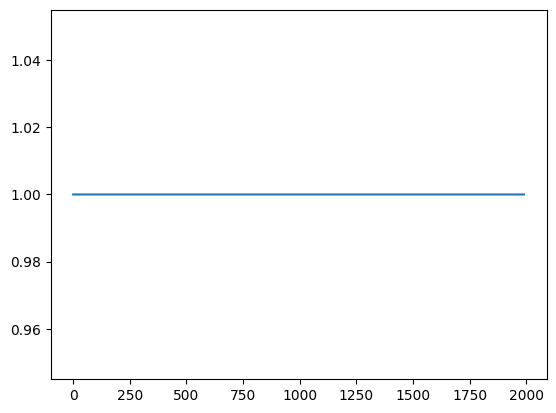

In [53]:
plot(range(0,len(classes_pred)),[x[7] for x in classes_pred])

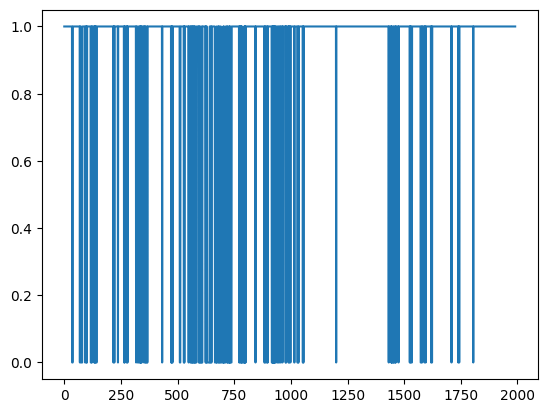

In [54]:
plot(range(0,len(classes_pred)),[x[8] for x in classes_pred])

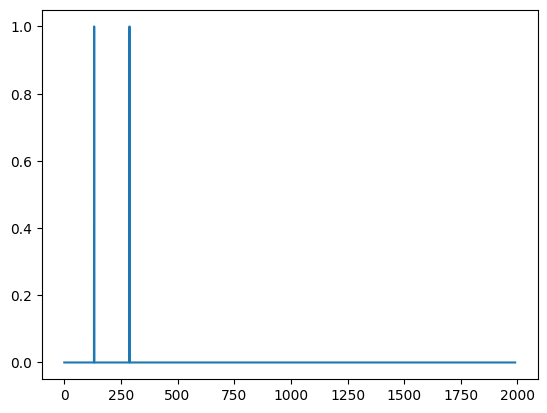

In [55]:
plot(range(0,len(classes_pred)),[x[9] for x in classes_pred])

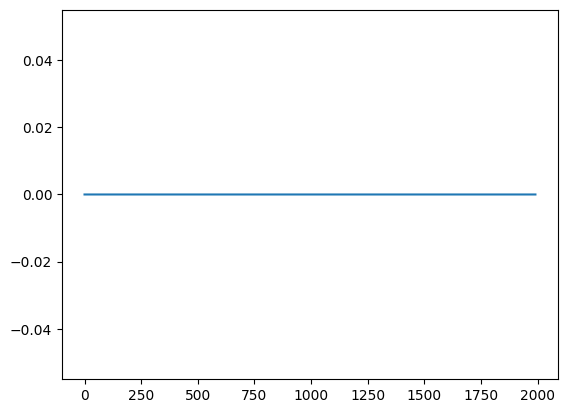

In [56]:
plot(range(0,len(classes_pred)),[x[10] for x in classes_pred])

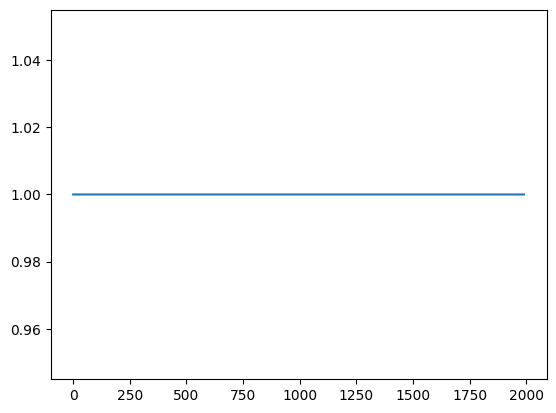

In [57]:
plot(range(0,len(classes_pred)),[x[11] for x in classes_pred])

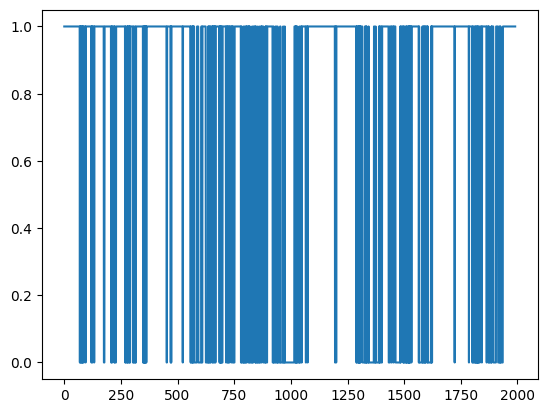

In [58]:
plot(range(0,len(classes_pred)),[x[12] for x in classes_pred])